In [ ]:
# %% libraries
import pandas as pd
from numpy import abs
import numpy as np
import matplotlib.pyplot as plt

from scipy import fft

import datetime as dt
import os,sys

_FILE_DIR = os.path.abspath("")
_SRC_DIR = os.path.dirname(_FILE_DIR)
sys.path.append(_SRC_DIR)

# local imports
import tsFB.data.prototyping_metrics as pm
import tsFB.utils.time_chunking as tc
import tsFB.build_filterbanks as fb

# Prepare test data

In [2]:
# %% Get data

year = '2019'
month = '05'
test_cdf_file_path =_SRC_DIR+fb._OMNI_MAG_DATA_DIR+ year +'/omni_hro_1min_'+ year+month+'01_v01.cdf'

mag_df = fb.get_test_data(fname_full_path=test_cdf_file_path)
cols = ['BY_GSE']
mag_df=mag_df[cols]
mag_df

,BY_GSE
2019-05-15 00:00:00,474.4
2019-05-15 00:01:00,475.3
2019-05-15 00:02:00,473.6
2019-05-15 00:03:00,472.6
2019-05-15 00:04:00,470.5
...,...
2019-05-15 23:56:00,419.9
2019-05-15 23:57:00,417.7
2019-05-15 23:58:00,413.2
2019-05-15 23:59:00,411.5


In [3]:
# %% Prepare FT of test data for Fourier applications

cadence = dt.timedelta(seconds=60)

mag_df.sort_index(inplace=True)
mag_df.interpolate(method='index', kind='linear',limit_direction='both',inplace=True)
df_index=pd.date_range(start=mag_df.index[0], end=mag_df.index[-1], freq=cadence)

sig_fft_df = fft.rfftn(mag_df - mag_df.mean(),axes=0)

# Detrending & Smoothing via Convolution in the Time Domain
The Smoothing and Detrending code from "time_chunking.py" (not excutable here)

```python
mag_df=mag_df[cols]
mag_df.sort_index(inplace=True)
preprocessed_mag_df = mag_df.copy()

if detrend_window > timedelta(seconds=0):
    LOG.debug('Detrending')
    smoothed = preprocessed_mag_df.rolling(detrend_window,
        center=True
    ).mean()
    # Subtract the detrend_window (e.g. 30 minutes or 1800s) to detrend
    preprocessed_mag_df = preprocessed_mag_df - smoothed

if smooth_window > timedelta(seconds=0):
    LOG.debug('Smoothing')
    preprocessed_mag_df = preprocessed_mag_df.rolling(smooth_window,
        center=True
    ).mean()
```

In [4]:
SM_window = dt.timedelta(seconds=3000)
DT_window = dt.timedelta(seconds=18000)

In [5]:
# %% Detrending from time_chunking code script
detrend_y = tc.preprocess_smooth_detrend(mag_df=mag_df-mag_df.mean(),
                                        cols=cols,
                                        detrend_window=DT_window,
                                        smooth_window=SM_window)

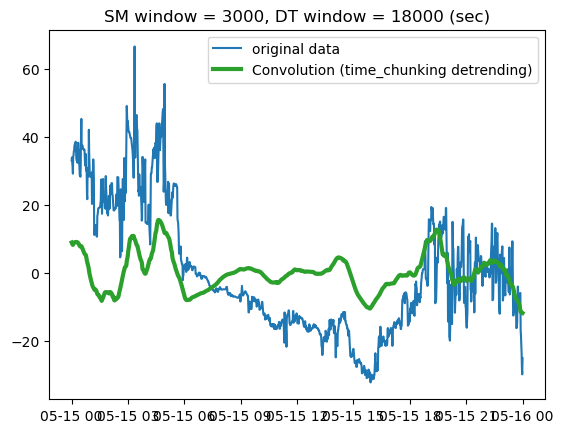

In [6]:
# %% Compare

plt.plot(mag_df.index,mag_df[:]-mag_df.mean(),label='original data')
plt.plot(mag_df.index,detrend_y,color='tab:green',linewidth=3,label='Convolution (time_chunking detrending)')
plt.title(f'SM window = {int(SM_window.total_seconds())}, DT window = {int(DT_window.total_seconds())} (sec)')
plt.legend()
plt.show()

# Theoretical Frequency Response

**(Formula from [Ch. 15 of *Digital Signal Processing Textbook*](https://www.dspguide.com/CH15.PDF)**)

Frequency response of an $M$ point moving average filter. The frequency, $f$, runs between $0$ and $0.5$. For $f = 0$, use $H[f] = 1$

$$H_M[f] = \frac{\sin(\pi f W_M)}{W_M\sin(\pi f)}$$

In [7]:
# %% Ch. 15 Formula
def moving_avg_freq_response(f,window=dt.timedelta(minutes=3000),cadence=dt.timedelta(minutes=1)):
    n = int(window.total_seconds()/cadence.total_seconds())
    numerator = np.sin(np.pi*f*n)
    denominator = n*np.sin(np.pi*f)
    return abs(numerator/denominator)

## Detrending in the frequency domain
**JK's notation:** $\operatorname{FT}(x) = \widetilde{x}$

Since detrending in the time domain is `detrended_sig = signal - mvg_avg(window)`, the frequency response of detrending ($DT$) with detrending window, $W_d$, should be

\begin{align*}
\widetilde{DT}[f] &= 1 - H_d[f] \\ 
&= 1 - \frac{\sin(\pi f W_d)}{W_d \sin(\pi f)}
\end{align*}

In [8]:
# Build theoretical frequency response 
data_len = mag_df.shape[0]  
freq_spectrum = np.linspace(0.0001,data_len/2,(data_len//2)+1)
DT_theory = moving_avg_freq_response(f=freq_spectrum,
                                        window=DT_window,
                                        cadence=cadence)
DT_theory = 1 - DT_theory

Text(0.5, 1.0, 'Zoomed in')

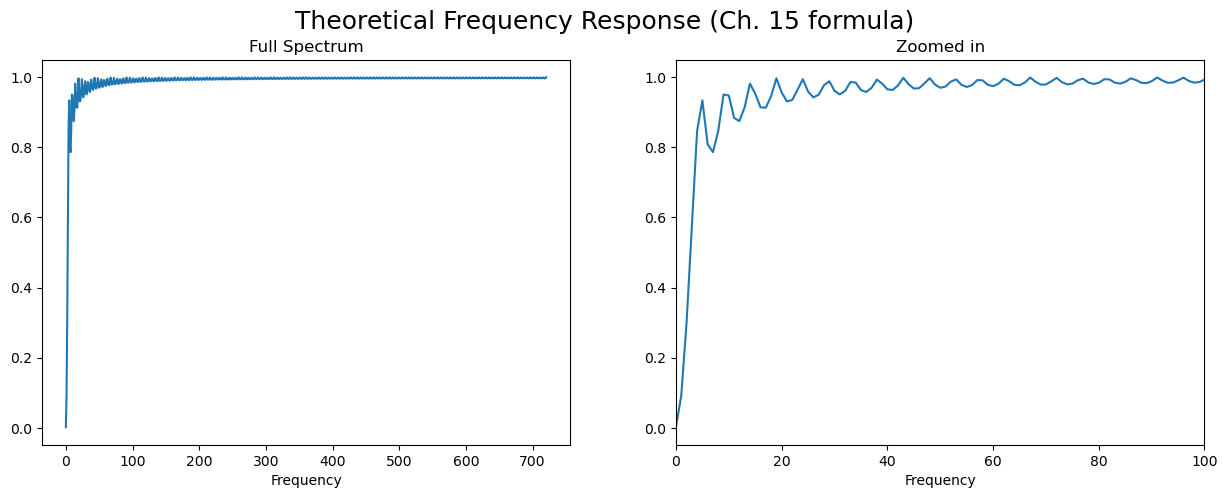

In [9]:
# plot frequency response
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle("Theoretical Frequency Response (Ch. 15 formula)",fontsize=18)
axes[0].plot(freq_spectrum,DT_theory)
axes[0].set_xlabel("Frequency")
axes[0].set_title('Full Spectrum')
axes[1].plot(freq_spectrum,DT_theory)
axes[1].set_xlim(0,100)
axes[1].set_xlabel("Frequency")
axes[1].set_title('Zoomed in')

## Smoothing in the Frequency Domain
Smoothing (SM), with smoothing window $W_s$, only uses the moving average frequency response formula directly. In other words,

\begin{align*}
\widetilde{SM}[f] &= H_s[f] \\ 
&= \frac{\sin(\pi f W_s)}{W_s \sin(\pi f)}
\end{align*}


In [10]:
SM_theory = moving_avg_freq_response(f=freq_spectrum,
                                        window=SM_window,
                                        cadence=cadence)

Text(0.5, 1.0, 'Zoomed in')

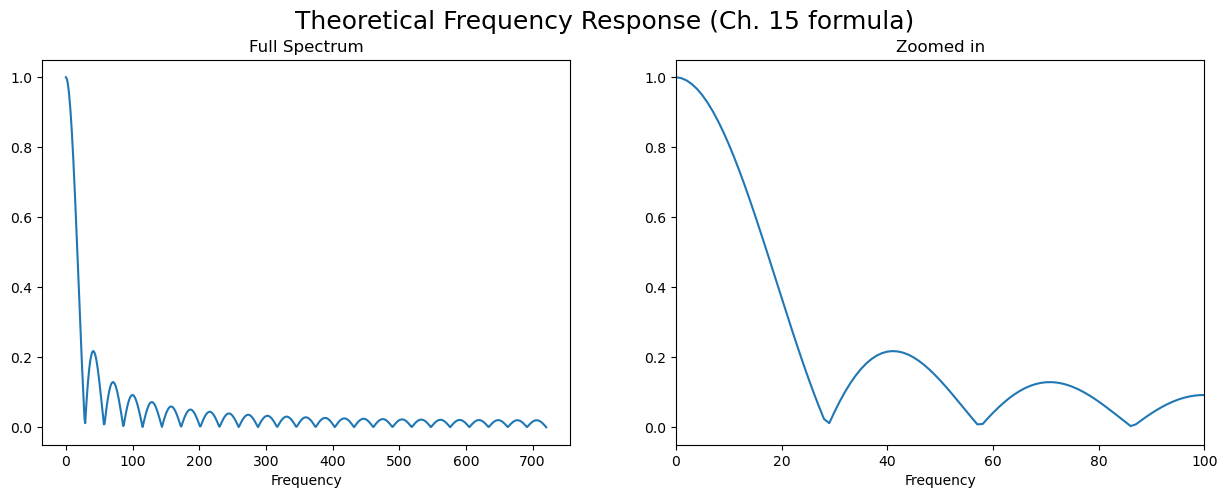

In [11]:
# plot frequency response
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle("Theoretical Frequency Response (Ch. 15 formula)",fontsize=18)
axes[0].plot(freq_spectrum,SM_theory)
axes[0].set_xlabel("Frequency")
axes[0].set_title('Full Spectrum')
axes[1].plot(freq_spectrum,SM_theory)
axes[1].set_xlim(0,100)
axes[1].set_xlabel("Frequency")
axes[1].set_title('Zoomed in')

## Smoothing & Detrending

As a reminder, the time_chunking code is as follows:

```python
mag_df=mag_df[cols]
mag_df.sort_index(inplace=True)
preprocessed_mag_df = mag_df.copy()

if detrend_window > timedelta(seconds=0):
    LOG.debug('Detrending')
    smoothed = preprocessed_mag_df.rolling(detrend_window,
        center=True
    ).mean()
    # Subtract the detrend_window (e.g. 30 minutes or 1800s) to detrend
    preprocessed_mag_df = preprocessed_mag_df - smoothed

if smooth_window > timedelta(seconds=0):
    LOG.debug('Smoothing')
    preprocessed_mag_df = preprocessed_mag_df.rolling(smooth_window,
        center=True
    ).mean()
```

From here we see that we smooth a detrended signal (i.e. first perform detrending and then smooth that result.)

### Apply each individually

Judging by the above, the combined application of smoothing and detrending looks to be something like this.

\begin{align*}
\widetilde{Y}[f] &= (\widetilde{s}[f] \cdot \widetilde{DT}[f]) \cdot \widetilde{SM}[f]
\end{align*}

(where $\widetilde{Y}[f]$ and $\widetilde{s}[f]$ are the Fourier transforms of the output and input signal respectively)

In [12]:
# Apply filter: theoretical frequency response
Y = (sig_fft_df.ravel()*DT_theory)*SM_theory
filtered_y = np.real(fft.irfft(Y))

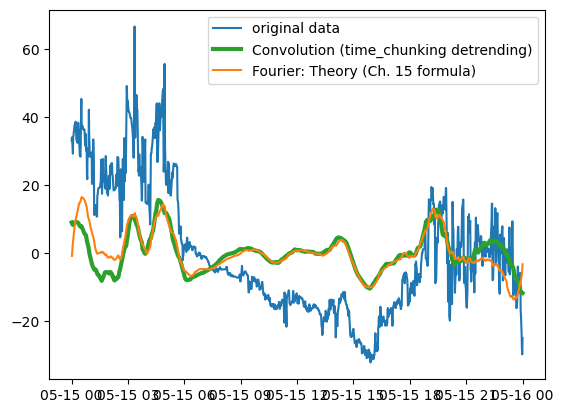

In [13]:
# Compare
plt.plot(mag_df.index,mag_df[:]-mag_df.mean(),label='original data')
plt.plot(mag_df.index,detrend_y,color='tab:green',linewidth=3,label='Convolution (time_chunking detrending)')
plt.plot(mag_df.index[1:],filtered_y,color='tab:orange',label='Fourier: Theory (Ch. 15 formula)')
# plt.vlines(min(mag_df.index)+(DT_window-SM_window),-100,100,linestyles='dashed',color='black')
# plt.vlines(max(mag_df.index)-(DT_window-SM_window),-100,100,linestyles='dashed',color='black')
# plt.title(f'Detrending window = {int(window.total_seconds())} seconds')
plt.legend()
plt.show()

So the combined frequency response is perhaps just a product of the two responses, and looks something like this

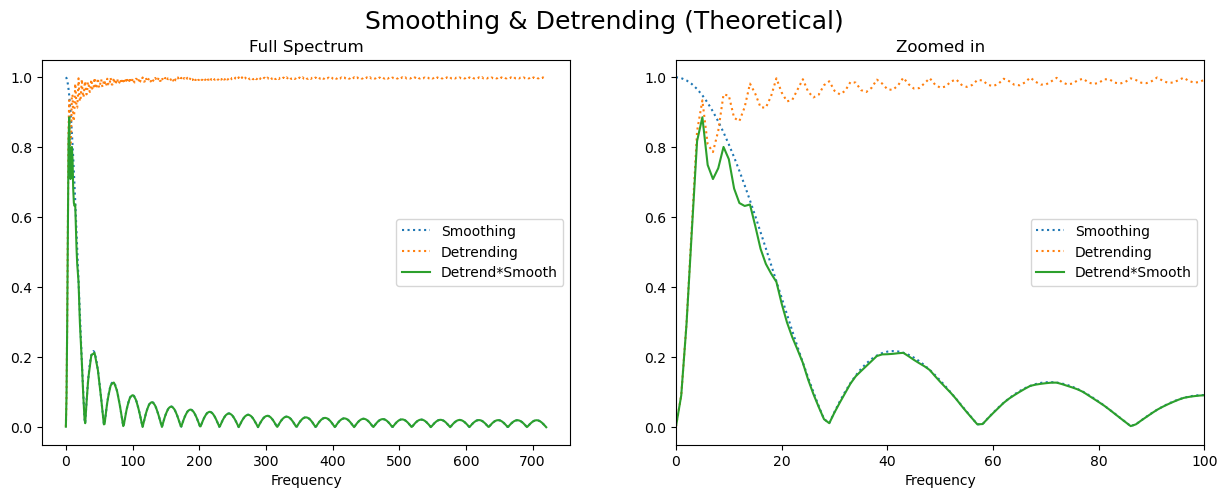

In [14]:
# plot frequency response
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle("Smoothing & Detrending (Theoretical)",fontsize=18)
axes[0].plot(freq_spectrum,SM_theory,linestyle='dotted',label='Smoothing')
axes[0].plot(freq_spectrum,DT_theory,linestyle='dotted',label='Detrending')
axes[0].plot(freq_spectrum,DT_theory*SM_theory,label='Detrend*Smooth')
axes[0].set_xlabel("Frequency")
axes[0].set_title('Full Spectrum')
axes[1].plot(freq_spectrum,SM_theory,linestyle='dotted',label='Smoothing')
axes[1].plot(freq_spectrum,DT_theory,linestyle='dotted',label='Detrending')
axes[1].plot(freq_spectrum,DT_theory*SM_theory,label='Detrend*Smooth')
axes[1].set_xlim(0,100)
axes[1].set_xlabel("Frequency")
axes[1].set_title('Zoomed in')
axes[0].legend()
axes[1].legend()

### Combine to "single filter"

Just to check for consistent results, lets combine the frequency response to a single variable.

i.e.

$$\text{FR}[f] = \widetilde{DT}[f] \cdot \widetilde{SM}[f] $$

(Again, where $\widetilde{DT}[f] = 1 - H_d[f]$, and $\widetilde{SM}[f]=H_s[f]$)

---

This is just to check if

\begin{align*}
\widetilde{Y}[f] &= (\widetilde{s}[f] \cdot \widetilde{DT}[f]) \cdot \widetilde{SM}[f] \\
&= \widetilde{s}[f] \cdot \text{FR}[f] \\
&= \widetilde{s}[f] \cdot (\widetilde{DT}[f] \cdot \widetilde{SM}[f]) \\
\end{align*}

which should be consistent with the mathematical properties of convolutions.

In [15]:
FR_theory = DT_theory*SM_theory

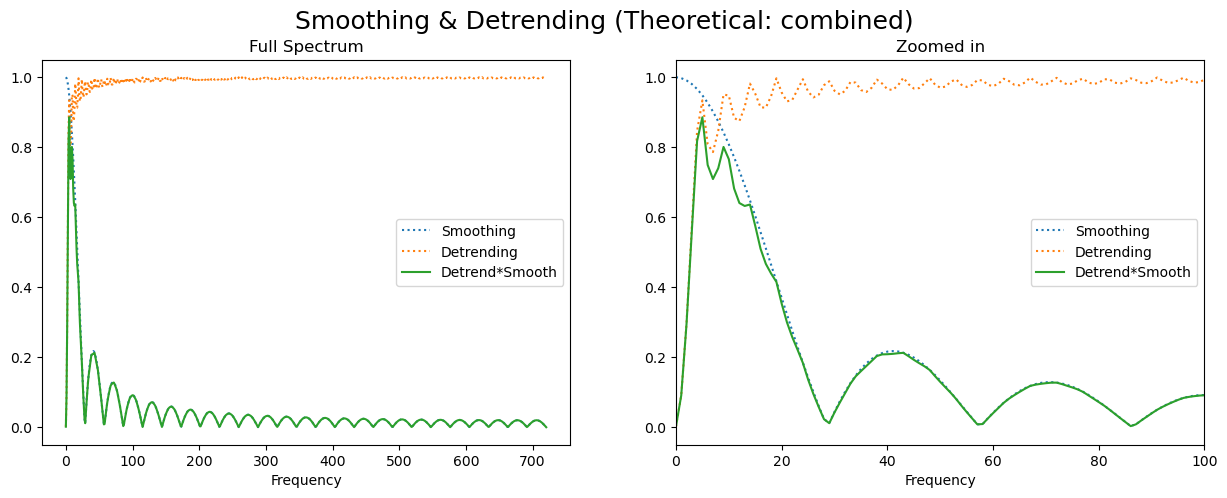

In [16]:
# plot frequency response
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle("Smoothing & Detrending (Theoretical: combined)",fontsize=18)
axes[0].plot(freq_spectrum,SM_theory,linestyle='dotted',label='Smoothing')
axes[0].plot(freq_spectrum,DT_theory,linestyle='dotted',label='Detrending')
axes[0].plot(freq_spectrum,FR_theory,label='Detrend*Smooth')
axes[0].set_xlabel("Frequency")
axes[0].set_title('Full Spectrum')
axes[1].plot(freq_spectrum,SM_theory,linestyle='dotted',label='Smoothing')
axes[1].plot(freq_spectrum,DT_theory,linestyle='dotted',label='Detrending')
axes[1].plot(freq_spectrum,FR_theory,label='Detrend*Smooth')
axes[1].set_xlim(0,100)
axes[1].set_xlabel("Frequency")
axes[1].set_title('Zoomed in')
axes[0].legend()
axes[1].legend()

In [17]:
# Apply filter: theoretical frequency response
Y = sig_fft_df.ravel()*FR_theory
filtered_y = np.real(fft.irfft(Y))

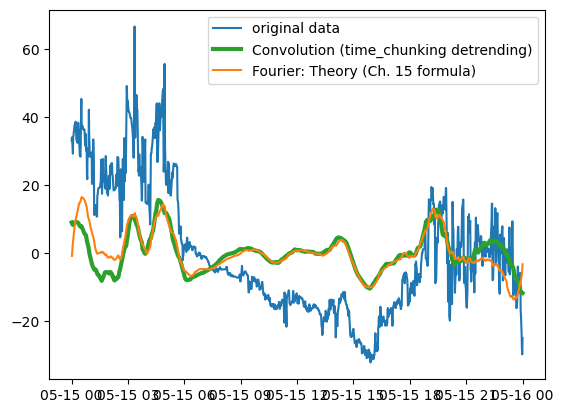

In [18]:
# Compare
plt.plot(mag_df.index,mag_df[:]-mag_df.mean(),label='original data')
plt.plot(mag_df.index,detrend_y,color='tab:green',linewidth=3,label='Convolution (time_chunking detrending)')
plt.plot(mag_df.index[1:],filtered_y,color='tab:orange',label='Fourier: Theory (Ch. 15 formula)')
# plt.vlines(min(mag_df.index)+(DT_window-SM_window),-100,100,linestyles='dashed',color='black')
# plt.vlines(max(mag_df.index)-(DT_window-SM_window),-100,100,linestyles='dashed',color='black')
# plt.title(f'Detrending window = {int(window.total_seconds())} seconds')
plt.legend()
plt.show()

### Frequency response of Smoothing & Detrending

With the consistency above, it appears that the frequency response of the combined process of smoothing and detrending can be simplified to the product of the respective frequency responses.

\begin{align*}

\widetilde{DTSM}[f] &=  \widetilde{DT}[f] \cdot \widetilde{SM}[f]\\

&= (1-H_d[f]) \cdot (H_s[f])\\

&= \left(1 - \frac{\sin (\pi f W_d)}{W_d \sin (\pi f)}\right) \cdot \left(\frac{\sin (\pi f W_s)}{W_s \sin (\pi f)}\right) 

\end{align*}

Where the final preprocessed signal ($Y[t]$) can be obtained by,

\begin{align*}
\widetilde{Y}[f] &= \widetilde{s}[f] \cdot \widetilde{DTSM}[f] \\
\Rightarrow Y[t] &= \text{IFT}(\widetilde{Y}[f])\\
\end{align*}


# Empirical application of moving avg. filter



In [19]:
# useful numbers
data_len = mag_df.shape[0]                              # length of data (i.e. number of samples)
sample_numbers = np.linspace(0,data_len,data_len)       # array of sample numbers
n_sm= int(SM_window.total_seconds()/cadence.total_seconds()) # number of "sample points" in the window (w.r.t. cadence)
n_dt = int(DT_window.total_seconds()/cadence.total_seconds())

## Smoothing

In [20]:
# Make the box
box_filter_SM = np.zeros(data_len) # start with array of zeros of size data_len
print("length of filter matches data length:",len(box_filter_SM)==data_len)

dx = (data_len-n_sm)//2            # the number of zeros to center the box

box_filter_SM[dx:dx+n_sm] = 1         # set values to one
print(f'sum of ones (should equal {n_sm}): {sum(box_filter_SM)}')

# Normalize the box
box_filter_SM = box_filter_SM/np.sum(box_filter_SM)


length of filter matches data length: True
sum of ones (should equal 50): 50.0


In [21]:
# FFT of the box filter
SM_empirical = fft.rfft(box_filter_SM)
#print(FR_empirical.shape)

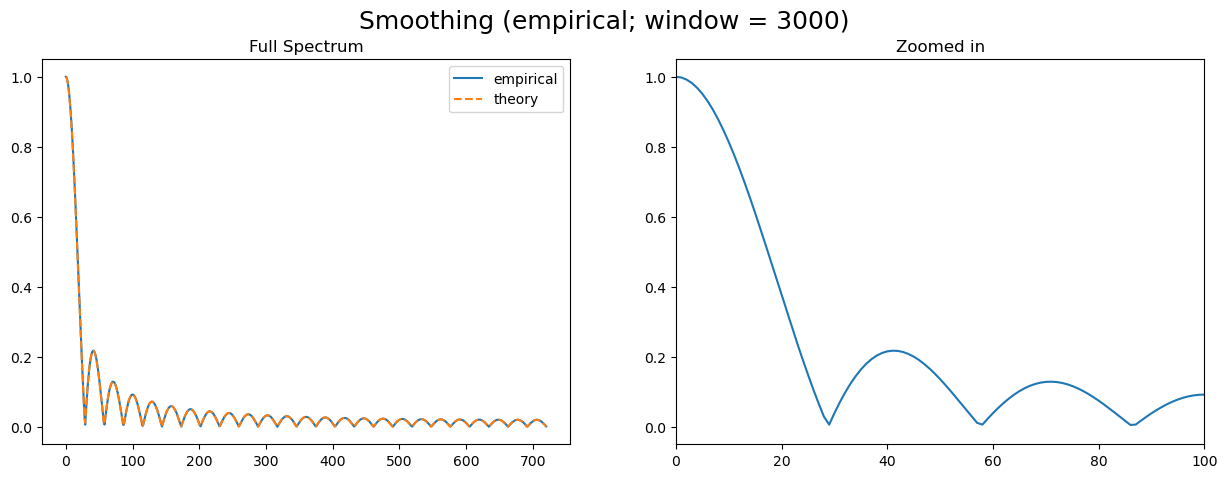

In [22]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axes[0].plot(np.abs(SM_empirical),label='empirical')
axes[0].plot(SM_theory,linestyle='dashed',label='theory')
axes[0].set_title('Full Spectrum')
axes[1].plot(np.abs(SM_empirical))
axes[1].set_xlim(0,100)
axes[1].set_title('Zoomed in')
fig.suptitle(f'Smoothing (empirical; window = {int(SM_window.total_seconds())})',fontsize=18)
axes[0].legend()

## Detrending

In [23]:
# Make the box
box_filter_DT = np.zeros(data_len) # start with array of zeros of size data_len
print("length of filter matches data length:",len(box_filter_DT)==data_len)

dx = (data_len-n_dt)//2            # the number of zeros to center the box

box_filter_DT[dx:dx+n_dt] = 1         # set values to one
print(f'sum of ones (should equal {n_dt}): {sum(box_filter_DT)}')

# Normalize the box
box_filter_DT = box_filter_DT/np.sum(box_filter_DT)


length of filter matches data length: True
sum of ones (should equal 300): 300.0


In [24]:
# FFT of the box filter
DT_empirical = fft.rfft(box_filter_DT)
DT_empirical = 1 - abs(DT_empirical)
#print(FR_empirical.shape)

Text(0.5, 0.98, 'Detrending (empirical; window = 18000)')

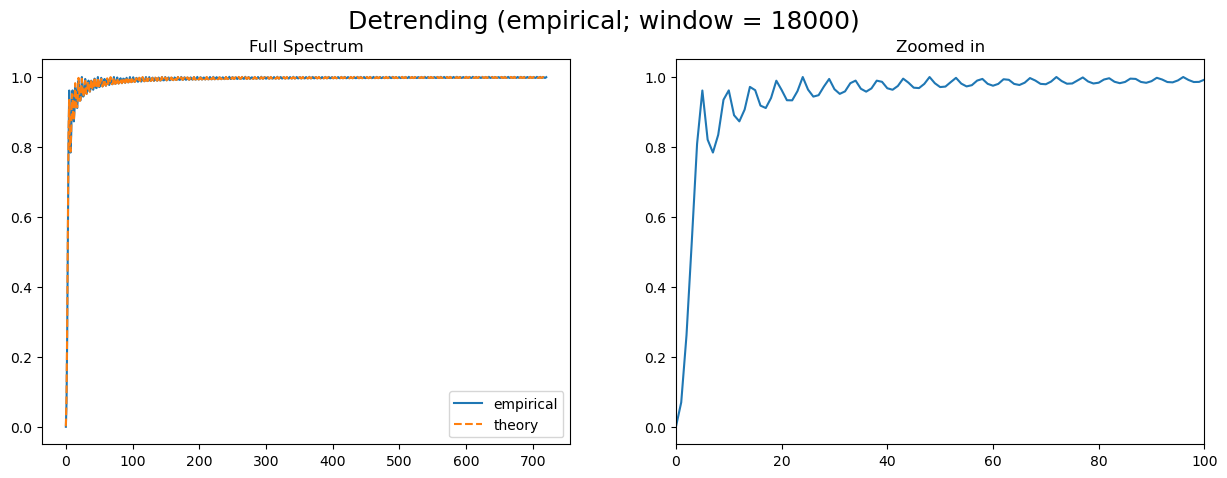

In [25]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axes[0].plot(np.abs(DT_empirical),label='empirical')
axes[0].plot(DT_theory,linestyle='dashed',label='theory')
axes[0].set_title('Full Spectrum')
axes[1].plot(np.abs(DT_empirical))
axes[1].set_xlim(0,100)
axes[1].set_title('Zoomed in')
axes[0].legend()
fig.suptitle(f'Detrending (empirical; window = {int(DT_window.total_seconds())})',fontsize=18)

## Smoothing & Detrending

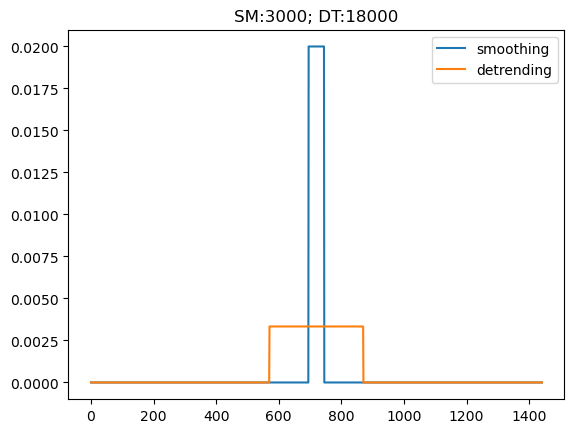

In [26]:
# visualize both filters
plt.plot(sample_numbers,box_filter_SM,label=f'smoothing')
plt.plot(sample_numbers,box_filter_DT,label=f'detrending')
plt.title(f'SM:{int(SM_window.total_seconds())}; DT:{int(DT_window.total_seconds())}')
plt.legend()

In [27]:
FR_empirical = DT_empirical*SM_empirical

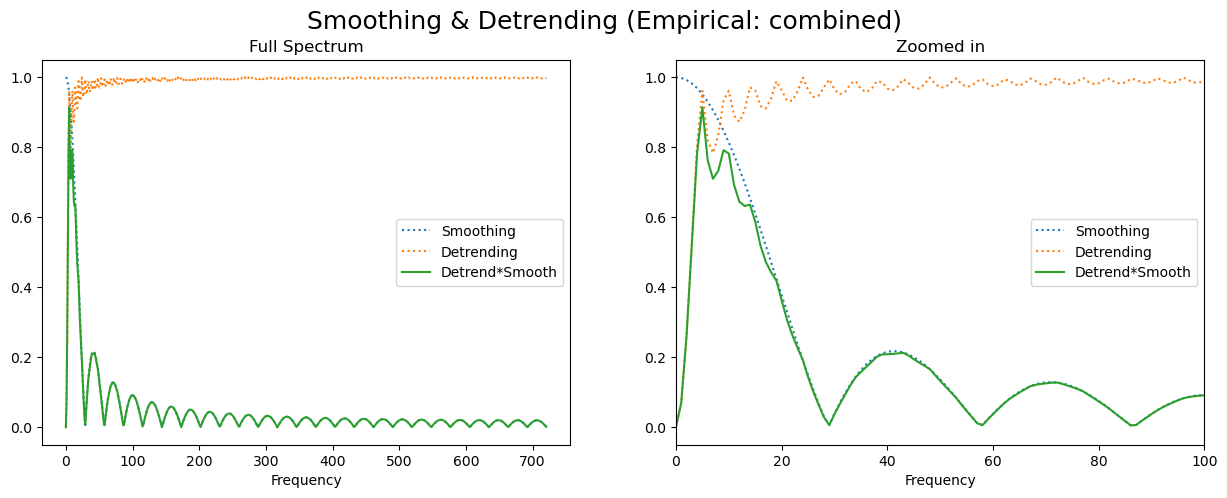

In [28]:
# plot frequency response
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle("Smoothing & Detrending (Empirical: combined)",fontsize=18)
axes[0].plot(freq_spectrum,abs(SM_empirical),linestyle='dotted',label='Smoothing')
axes[0].plot(freq_spectrum,abs(DT_empirical),linestyle='dotted',label='Detrending')
axes[0].plot(freq_spectrum,abs(FR_empirical),label='Detrend*Smooth')
axes[0].set_xlabel("Frequency")
axes[0].set_title('Full Spectrum')
axes[1].plot(freq_spectrum,abs(SM_empirical),linestyle='dotted',label='Smoothing')
axes[1].plot(freq_spectrum,abs(DT_empirical),linestyle='dotted',label='Detrending')
axes[1].plot(freq_spectrum,abs(FR_empirical),label='Detrend*Smooth')
axes[1].set_xlim(0,100)
axes[1].set_xlabel("Frequency")
axes[1].set_title('Zoomed in')
axes[0].legend()
axes[1].legend()

In [29]:
# Apply empirical filter
Y_box = sig_fft_df.ravel()*abs(FR_empirical)
box_filtered_y = np.real(fft.irfft(Y_box))

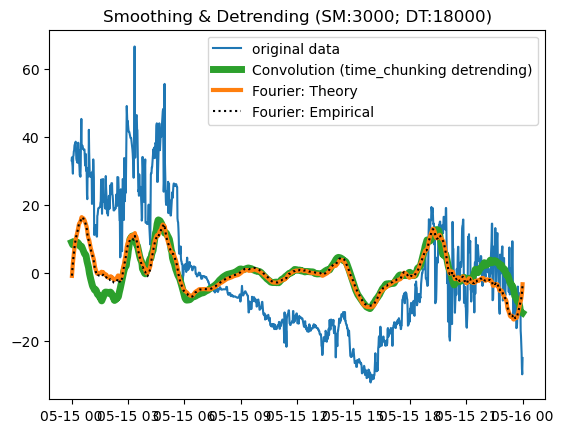

In [30]:
plt.plot(mag_df.index,mag_df[:]-mag_df.mean(),label='original data')
plt.plot(mag_df.index,detrend_y,color='tab:green',linewidth=5,label='Convolution (time_chunking detrending)')
plt.plot(mag_df.index[1:],filtered_y,color='tab:orange',linewidth=3,label='Fourier: Theory')
plt.plot(mag_df.index[1:],box_filtered_y,color='black',linestyle='dotted',label='Fourier: Empirical')
# plt.vlines(min(mag_df.index)+window,-100,100,linestyles='dashed',color='gray')
# plt.vlines(max(mag_df.index)-window,-100,100,linestyles='dashed',color='gray')
plt.title(f'Smoothing & Detrending (SM:{int(SM_window.total_seconds())}; DT:{int(DT_window.total_seconds())})')
plt.legend()
plt.show()


---

# Conclusion/Summary: Frequency response of Detrending + Smoothing:

Frequency response of an $M$ point moving average filter:

$$H_M[f] = \frac{\sin(\pi f W_M)}{W_M\sin(\pi f)}$$

**Frequency response of detrending (DT)** with window $W_d$,

\begin{align*}

\widetilde{DT}[f] &= 1 - H_d[f] \\

&= 1 - \frac{\sin (\pi f W_d)}{W_d \sin (\pi f)}

\end{align*}

**Frequency response of smoothing (SM)** with window $W_s$,

\begin{align*}

\widetilde{SM}[f] &= H_s[f] \\

&= \frac{\sin (\pi f W_s)}{W_s \sin (\pi f)}

\end{align*}

**Frequency response of *both* detrending and smoothing** (just product of the above two)

\begin{align*}

\widetilde{DTSM}[f] &=  \widetilde{DT}[f] \cdot \widetilde{SM}[f] \\

&= (1-H_d[f]) \cdot (H_s[f]) \\

&= \left(1 - \frac{\sin (\pi f W_d)}{W_d \sin (\pi f)}\right) \cdot \left(\frac{\sin (\pi f W_s)}{W_s \sin (\pi f)}\right) 

\end{align*}
